## 📧 Classificador de spam

In [ ]:
import pandas as pd

df = pd.read_csv('spam.csv')
df.rename(columns={'v1': 'labels'}, inplace=True)
df.rename(columns={'v2': 'email'}, inplace=True)
df.head(70)

,labels,email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
65,spam,"As a valued customer, I am pleased to advise y..."
66,ham,"Today is \song dedicated day..\"" Which song wi..."
67,spam,Urgent UR awarded a complimentary trip to Euro...
68,spam,"Did you hear about the new \Divorce Barbie\""? ..."


### ⚙️ pré-processamento

Antes de começar a trabalhar com os dados em si, devemos fazer um pré-processamento, no intuito de estruturar o texto de forma a apresentar informações relevantes e organizadas.


In [ ]:
import unicodedata
import re

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def pre_processamento(text):
  text = unicodedata.normalize("NFKD", text) # remoção de caracteres especiais
  text = re.sub(r'[^\w\s]', '', text) # remoção de pontuação e acentos
  text = text.lower() # alteração para letras minúsculas
  return text

df.email = df.email.apply(pre_processamento)
df.email = df['email'].apply(word_tokenize) # tokenização

# remoção das stopwords
i = 0
for text in df.email:
  meaningful_words = []
  for word in text:
    if word not in stopwords:
      meaningful_words.append(word)
  df.loc[i, 'email'] = ' '.join(meaningful_words)
  i += 1

df.email = df['email'].apply(word_tokenize) # tokenização
df.email[66]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['today',
 'song',
 'dedicated',
 'day',
 'song',
 'u',
 'dedicate',
 'send',
 'ur',
 'valuable',
 'frnds',
 'first',
 'rply']

### 🌱 stemização

Para esse projetinho, foi escolhida a Stemização com o o algoritimo de Porter para a redução das palavras em raízes. Entretanto, o modelo também foi testado utilizando o algoritmo de Lancaste, o que resultou em uma acurácia e matriz de confusão similar ao do algoritimo de escolha. Além disso, também foi testada a Lematização para a simplificação das palavras em sua forma básica, a qual resultou em uma acurácia similiar e matriz de confusão com a diferença de uma unidade nos erros de tipo I (diferença de uma unidade menor) e II (diferença de uma unidade maior). Dessa forma, optou-se pelo Porter pela sua maior velocidade de execução e por ter uma aplicação menos "radical", sendo mais eficiente para manutenção da semântica das palavras, como por exemplo para os termos "price" e "prize".

In [ ]:
porter = nltk.PorterStemmer()

porter_list = []
for i in range(len(df.email)):
    porter_tokens = []
    for word in df.email[i]:
        porter_tokens.append(porter.stem(word))
    porter_list.append(porter_tokens)

porter_text = []
for i in porter_list:
     porter_text.append(' '.join(i))

df.email = porter_text

df.head()

,labels,email
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think goe usf live around though


### 🎲 dados de treino e teste

Com os dados "limpos", podemos começar a analizar os dados. Dessa forma, priemeiro teremos a sua divisão entre dados de treino e dados de teste.

In [ ]:
from sklearn.model_selection import train_test_split
train, test, train_labels, test_labels = train_test_split(df.email, df.labels, test_size=0.2, stratify=df.labels, random_state=42)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

### 🎒 bag-of-words

Com o modelo bag-of-words podemos de transformar um texto em algo operacionalizável pelo computador, como números - binários.

In [ ]:
# formatando:
train = train.tolist()
test = test.tolist()

all_sentences = train + test

# bag-of-words
from sklearn.feature_extraction.text import CountVectorizer

def bow(textos):
  """ Entrada: uma lista de textos limpos.
  Saída: um vetor que indica quais são as palavras presentes nos textos e a quantidade de vezes que tais vocábulos aparecem. """
  vectorizer = CountVectorizer()
  frequencies = vectorizer.fit_transform(textos).toarray()
  return frequencies

bow_all = bow(all_sentences)

# separando novamente os dados de treino e teste
train = (bow_all)[:len(train)]
test = (bow_all)[-len(test):]

### ➕ algoritimo Naive Bayes

Com os dados separados, ultizou-se o modelo de classificação probabilisco Naive Bayes, treinando-o com os dados de treino, de forma a predizê-los.

In [ ]:
train_labels = train_labels.to_list()
test_labels = test_labels.to_list()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = MultinomialNB()
model.fit(train, train_labels)
predicted_categories = model.predict(test)

### 📊 avaliando o desempenho com uso de métricas

Por fim, será usado medidas quantitativas (métricas de avaliação) para fornecer informações sobre o desempenho do modelo. Para isso, foram utilizados a matriz de confusão, que compara as previsões do modelo com as classes reais, e a acurácia, que representa a proporção de predições corretas em relação ao total de predições. Nesse caso, apenas a acurácia não bastaria para analisar o desempenho, uma vez que há muito mais emails "ham" no dataset em comparação aos "spam". Assim, a matriz de confusão ajuda a observar se o modelo está classificando corretamente os emails como "spam" ou "ham".

A acurácia encontrada é de: 0.9766816143497757


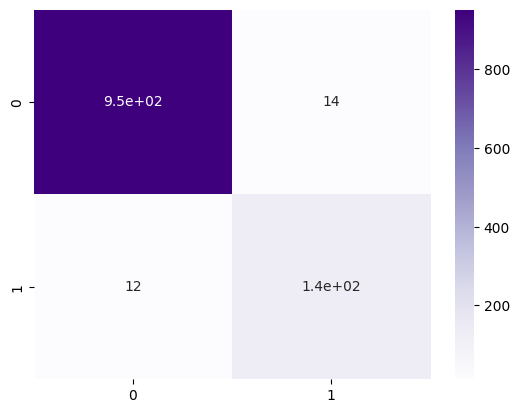

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# matriz de confusão:
matrix = confusion_matrix(test_labels, predicted_categories)
sns.heatmap(matrix, annot=True, cmap='Purples')

# acurácia:
accuracy = accuracy_score(test_labels, predicted_categories)
print('A acurácia encontrada é de:', accuracy)